In [1]:
import os
import pandas as pd
import cv2
from detector import get_info
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib
%matplotlib inline

Using cache found in C:\Users\virgi/.cache\torch\hub\ultralytics_yolov5_master
requirements: pandas>=1.1.4 not found and is required by YOLOv5, attempting auto-update...
requirements: Command 'pip install 'pandas>=1.1.4' ' returned non-zero exit status 1.
YOLOv5  2022-5-16 Python-3.7.8 torch-1.8.1+cu102 CUDA:0 (NVIDIA GeForce RTX 2060, 6144MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [2]:
model_folder = 'results/models/model_big_with_hand'
model = tf.keras.models.load_model(model_folder)

In [3]:
marks_names = ['hand_mark_'+str(i).zfill(2)+axis for i in range(21) for axis in ['x','y','z']]
train_labels = marks_names + ['hand_id']

users = pd.read_csv('users.csv')
train_ids = users[users['train']==1]['user_id'].values

f_name= 'results/hand_landmarks.csv'
data = pd.read_csv(f_name)
data['hand_id'] = np.where(data['hand']=='Left', 1, 0)
data.head()

,user,sex,sign,frame,hand,...,hand_mark_19z,hand_mark_20x,hand_mark_20y,hand_mark_20z,hand_id
0,user01,0,5,4,Right,...,-0.084381,1.000000,0.348559,-0.089569,0
1,user01,0,5,2,Right,...,-0.070153,1.000000,0.274275,-0.073769,0
2,user01,0,1,24,Right,...,-0.050475,0.470683,0.976509,-0.042765,0
3,user01,0,5,3,Right,...,-0.079948,1.000000,0.341380,-0.085815,0
4,user01,0,1,23,Right,...,-0.052067,0.495761,0.972848,-0.044382,0


In [4]:
def get_data(labels):  

    train_data = data[data['user'].isin(train_ids)]
    test_data = data[~data['user'].isin(train_ids)]

    X_train = train_data[labels].values
    X_test = test_data[labels].values

    y_train = train_data['sign'].values -1
    y_test = test_data['sign'].values -1
    
    return X_train, X_test, y_train, y_test

def get_model(input_size, output_size):
    model = keras.Sequential(
        [
            keras.Input(shape=(input_size,)),
            #layers.Dropout(0.1),
            layers.Dense(21, activation="relu"),
            #layers.Dropout(0.1),
            layers.Dense(10, activation="relu"),
            layers.Dense(output_size, activation='softmax'),
        ]
    )
    return model

In [5]:
X_train, X_test, y_train, y_test = get_data(marks_names + ['hand_id'])

In [6]:
predictions = model.predict(X_train, verbose=False)
y_pred_train = predictions.argmax(axis=-1)

predictions = model.predict(X_test, verbose=False)
y_pred_test = predictions.argmax(axis=-1)

In [7]:
train_matrix = confusion_matrix(y_train, y_pred_train)
test_matrix = confusion_matrix(y_test, y_pred_test)

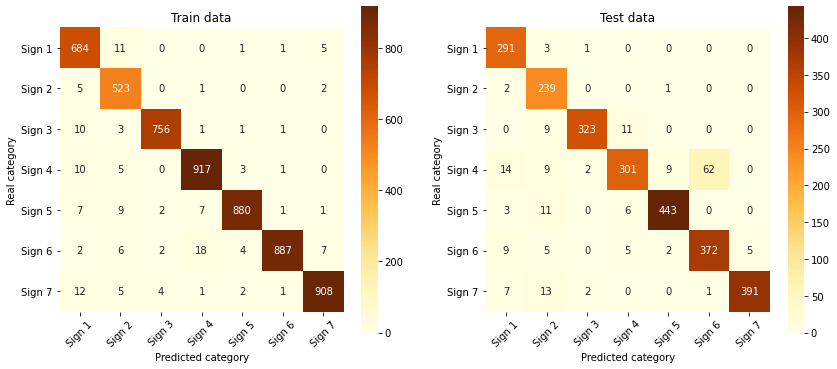

In [8]:
labels = ['Sign '+str(i) for i in range(1,8)]

fig, ax = plt.subplots(1,2,figsize=(14, 6))

sns.heatmap(train_matrix, annot=True, cmap="YlOrBr", square=True, ax=ax[0], xticklabels=labels, yticklabels=labels, fmt='g')
ax[0].set_yticklabels(labels, rotation=0)
ax[0].set_xticklabels(labels, rotation=45)
ax[0].set_ylabel('Real category')
ax[0].set_xlabel('Predicted category')
ax[0].set_title('Train data')
sns.heatmap(test_matrix, annot=True, cmap="YlOrBr", square=True, ax=ax[1], xticklabels=labels, yticklabels=labels, fmt='g')
ax[1].set_yticklabels(labels, rotation=0)
ax[1].set_xticklabels(labels, rotation=45)
ax[1].set_ylabel('Real category')
ax[1].set_xlabel('Predicted category')
ax[1].set_title('Test data')
plt.show()

In [9]:
# train with class_weight